# Calibration - Intensity
#### v2.0 | by André Maia Chagas, Katrin Franke, and Thomas Euler

This script allows estimating photoceptor excitation caused by a combination of light sources (e.g. LEDs) and dichroic filters used in a visual stimulator. To this end, spectral data from an Ocean Optics spectometer is recorded via USB (i.e. with the USB2000+ spectrometer, Ocean Optics) and converted into photoisomerization rates per cone photoreceptor type and LED. For details, see xxxx.

The spectrometer measurements rely on the open source library [python-seabreeze](https://github.com/ap--/python-seabreeze) written by Andreas Pohlmann. This library is a wrapper for the C++ API provided by Ocean Optics. For installation instructions and further support, see there.

*__Note:__ This script is used for the dichromatic (mouse) version of the visual stimulator; it can be easily adapted to other animals with more spectral sensitivites and light source/filter combinations.*

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.special as sse
from scipy.optimize import curve_fit
from IPython import display

# Helpers
#
import scripts.spectrum as spectrum
import scripts.progress_bar as pbar
import scripts.spectrometer_helper as sph

# Set graphics to be plotted in the notebook
#
%matplotlib inline 

# Seaborn plot settings
#
sns.set()

# Paths and file names
# (Don't change unless you know what you are doing)
#
path_LightSources   = "light-sources//"
path_Filters        = "filters//"
path_SpectCalibData = "spectrometer-calibration-files//"
path_Data           = "data//"
path_Opsins         = "opsins//"

txtFileNewLineStr   = "\r\n"

def setPlotStyle():
    # Presettings for figures
    #
    mpl.rcParams['figure.figsize'] = [10, 5]
    mpl.rc('font', size=10)          
    mpl.rc('axes', titlesize=12)    
    mpl.rc('axes', labelsize=12)    
    mpl.rc('xtick', labelsize=12)   
    mpl.rc('ytick', labelsize=12)   
    mpl.rc('legend', fontsize=12)   
    mpl.rc('figure', titlesize=12) 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Define photoreceptors

Load opsin spectra from text files in the respective folder:

* Text files are expected to have one column per opsin ... 
* ... plus one (the last one) for the scaling in x direction (wavelength, in 1-nm increments).
* All spectral files, including the filter and LED files loaded later, must have the same x range. In this version, 300 .. 699 nm is used.

In [3]:
x_wavelen_nm = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(2,)) # 300 .. 699 nm
mouseMOpsin  = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(1,))
mouseSOpsin  = np.loadtxt(path_Opsins +"mouse_cone_opsins.txt", usecols=(0,))

Define some properties as well as constants needed later to convert the data measured with the spectrometer into photoisomerizations.

*   `h`, Planck's constant [eV*s]
*   `c`, speed of light [m/s]
*   `eV_per_J`, conversion factor, [eV] per [J]
*   `ac_um2`, cone OS light collection area in [µm^2], see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.
*   `ar_um2`, rod OS light collection area, see above. A value of 0.5 is considered realistic.   
    

In [4]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]
ac_um2   = 0.2     
ar_um2   = 0.5

Organise photoreceptors as a list of dictionaries, with:

*   `name`, name of photoreceptor, used later for plots etc.
*   `peak_nm`, peak wavelength of opsin spectrum in [nm]          
*   `collecArea_um2`, see above
*   `spect`, opsin spectrum

In [5]:
MCone = {"name"           : "mouse_M_cone",
         "peak_nm"        : 511,
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseMOpsin}
SCone = {"name"           : "mouse_S_cone",
         "peak_nm"        : 360,         
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseSOpsin}
Rod   = {"name"           : "mouse_rod",
         "peak_nm"        : 510,         
         "collecArea_um2" : ar_um2, 
         "spect"          : []}

PRs   = [MCone, SCone, Rod]

Plot cone photoreceptor spectra:

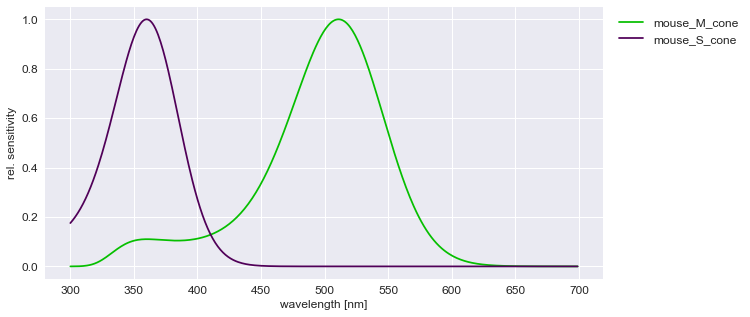

In [6]:
setPlotStyle()

for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spectrum.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="wavelength [nm]", ylabel="rel. sensitivity") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

## Define stimulus LED/filter combinations 
Load LED and filter (dicroic) spectra from text files in the respective folder. Files are expected to be organised as the photoreceptor data files except that they contain only two columns (wavelength, from 300 to 699 nm in 1-nm increments; relative transmission for filters and relative intensity for light sources).

In [7]:
# LED spectra
#
LED_Green_Name      = "LED_Green_590"
LED_Green           = np.loadtxt(path_LightSources +LED_Green_Name +".txt", usecols=(0,))
LED_UV_Name         = "LED_UV_385"
LED_UV              = np.loadtxt(path_LightSources +LED_UV_Name +".txt", usecols=(0,))

# Dicroic above the objective lens in the MOM
# (if not used, comment line that loads text file and uncomment next line)
#
Dichr_Obj_name     = "Filter_F73-063_z400-580-890"
Dichr_Obj          = np.loadtxt(path_Filters +Dichr_Obj_name +".txt", usecols=(0,))
#Dichr_Obj         = np.array(list([1.0]*len(LED_UV)))

... if one filter per LED is used, uncomment this part.


In [8]:
%%capture
# LED filter(s)
#
Filter_UV_Name      = "Filter_387_11"
Filter_UV           = np.loadtxt(path_Filters +Filter_UV_Name +".txt", usecols=(0,))
Filter_Green_Name   = "Filter_576_10"
Filter_Green        = np.loadtxt(path_Filters +Filter_Green_Name +".txt", usecols=(0,))

... if a dual-band filter is used, uncomment this part. Then the same filter is used for both LEDs.

In [9]:
%%capture
# LED filter(s)
# (here, one two-band-pass filter is used instead of one for each LED. Therefore,)
#
"""
Filter_UVGreen_name = "Filter_F59-003_390_575"
Filter_UV           = np.loadtxt(path_Filters +Filter_UVGreen_name +".txt", usecols=(0,))
Filter_Green        = np.loadtxt(path_Filters +Filter_UVGreen_name +".txt", usecols=(0,))
"""

Organise the LED/filter combinations and spectra as a list of dictionary, with:  
*   `name`, name of LED/filter combinations, used later for plots etc.
*   `peak_nm`, peak wavelength of LED/filter combination in [nm]          
*   `LED_spect`, spectrum of LED (same x range as the opsin spectra, that is from 300 to 699 nm, and with 1-nm resolution).
*   `filter_spect`, spectrum of filter
*   `spect`, resulting spectrum, is measured below
*   `spect_nw`, **???**
*   `spect_raw_bkg`, mean background spectrum (LED off or at minimum)
*   `spect_raw`, spectrum of LED at maximum, all trials
*   `spect_raw_avg`, mean spectrum of LED at maximum

In [10]:
%%capture
minWLen_nm              = 300
maxWLen_nm              = 699
n                       = maxWLen_nm -minWLen_nm +1
x_wavelen_nm            = np.array([v+minWLen_nm for v in range(n)], dtype=np.float64)

# Setup #2 green-UV lightcrafter 
# (through-the-condenser stimulation)
#
GrLED = {"name"         : "green",
         "peak_nm"      : 576,          # 0=determine from peak
         "bandwidth_nm" : 0,            # obsolete
         "LED_spect"    : LED_Green,    # LED spectrum (datasheet)
         "filter_spect" : Filter_Green, # filter spectrum (datasheet)
         "meas_n_trials": [10, 10],     # trials to measure for LED off and on
         "spect_nw_norm": None,   
         "spect_nw"     : None,   
         "spect_raw_bkg": None,   
         "spect_raw"    : None,   
         "spect_raw_fit": None,   
         "spect_raw_avg": None}   

UVLED = {"name"         : "UV",
         "peak_nm"      : 387,
         "bandwidth_nm" : 0,
         "LED_spect"    : LED_UV,
         "filter_spect" : Filter_UV,
         "meas_n_trials": [10, 50],         
         "spect_nw_norm": None,
         "spect_nw"     : None,        
         "spect_raw_bkg": None,
         "spect_raw"    : None,
         "spect_raw_fit": None,
         "spect_raw_avg": None}

LEDs = [GrLED, UVLED]         

"""
# TFT screen, for comparison
#
GrLED = {"name"         : "green",
         "peak_nm"      : 520,          # 0=determine from peak
         "bandwidth_nm" : 0,            # obsolete
         "LED_spect"    : [],           # LED spectrum (datasheet)
         "filter_spect" : [],           # filter spectrum (datasheet)
         "meas_n_trials": [10, 10],     # trials to measure for LED off and on
         "spect_nw_norm": None,   
         "spect_nw"     : None,   
         "spect_raw_bkg": None,   
         "spect_raw"    : None,   
         "spect_raw_fit": None,   
         "spect_raw_avg": None}   

BlLED = {"name"         : "blue",
         "peak_nm"      : 450,
         "bandwidth_nm" : 0,
         "LED_spect"    : [],
         "filter_spect" : [],
         "meas_n_trials": [10, 10],
         "spect_nw_norm": None,
         "spect_nw"     : None,        
         "spect_raw_bkg": None,
         "spect_raw"    : None,
         "spect_raw_fit": None,
         "spect_raw_avg": None}

ReLED = {"name"         : "red",
         "peak_nm"      : 650,
         "bandwidth_nm" : 0,
         "LED_spect"    : [],
         "filter_spect" : [],
         "meas_n_trials": [10, 10],
         "spect_nw_norm": None,
         "spect_nw"     : None,        
         "spect_raw_bkg": None,
         "spect_raw"    : None,
         "spect_raw_fit": None,
         "spect_raw_avg": None}

LEDs  = [ReLED, GrLED, BlLED]
"""

Plot theoretical spectra of LED/filter combinations together with cone photoreceptors:

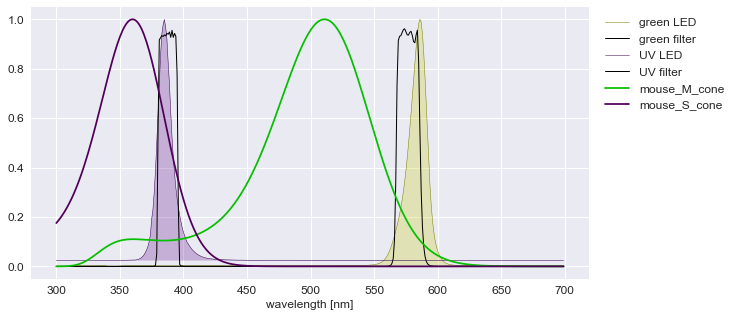

In [11]:
for LED in LEDs:  
    if len(LED["LED_spect"]) == 0: 
        continue
    
    col_lo = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    plt.plot(x_wavelen_nm, LED["LED_spect"], color=col_lo, 
             label=LED["name"] +" LED", linewidth=0.5)
    plt.fill(x_wavelen_nm, LED["LED_spect"], facecolor=col_hi, alpha=0.25)        
    plt.plot(x_wavelen_nm, LED["filter_spect"], color="black", 
             label=LED["name"] +" filter", linewidth=1)
    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spectrum.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        plt.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

plt.gca().set(xlabel="wavelength [nm]", ylabel="") 
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

## Spectrometer measurements
This section allows measuring the light sources (e.g. LEDs) using a spectrometer. The measured data is stored in the data path (for details, see below) and can also be re-loaded instead of performing a measurement. This way, notebooks can be reproduced based on the stored spectral data.

### Import calibration file for spectrometer
For each wavelength, the file contains corresponding [µJ/count] correlation, which will be used to calibrate the readings from the spectrometer.  
*__Note:__ These files need to be obtained for each individual device.*

In [12]:
spm_fileName     = path_SpectCalibData +"USB2+F02461_20171108_CC.Irradcal" 
spm_serialNumber = "USB2+F02461"

(spm_calib_values, 
 spm_calib_wavelengths) = sph.load_calibration_curves(sph.DevType.OO_USB2000, spm_fileName, spm_serialNumber)

Plot spectometer calibration curve

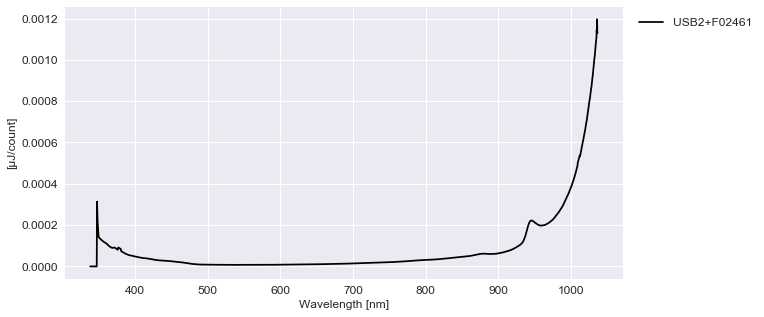

In [13]:
plt.plot(spm_calib_wavelengths, spm_calib_values, color="black", label=spm_serialNumber)
plt.gca().set(xlabel="Wavelength [nm]", ylabel="[µJ/count]")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


### Define measurement parameters
For the measurement and later for the calculation of photoisomerization rates, the area (`A_detect_um2`) of the measured light spot -- or, if it overfills the sensor of the spectrometer, the area of the sensor (e.g. the diffusor window of the spectrometer) -- is needed. Also required is the integration time (`int_time_s`) of the spectrometer.  


*__Note:__ In case of the Ocean Optics USB2000 used here, the area of the diffusor window is 0.113411cm².*  
*__Note:__ The integration time should be changed if output is saturated. To obtain [µJ/s] with the USB2000, use 1 s.*

In [14]:
# Setup #2 green-UV lightcrafter 
# (through-the-condenser stimulation)
#
int_time_s    = 1.0 
r_stimulus_um = 250  # light spot smaller than diffusor window

"""
# TFT screen, for comparison
#
int_time_s    = 1.0 
r_stimulus_um = 1900 # diffusor window overfilled
"""

A_detect_um2  = math.pi*(r_stimulus_um)**2
print("Illuminated area is {0:.3e} µm2 (= {1:.3} cm²)".format(A_detect_um2, A_detect_um2 *1E-8))

Illuminated area is 1.963e+05 µm2 (= 0.00196 cm²)


### Connect and setup the spectrometer
Select the device using its serial number and set the integration time in [s].   

In [15]:
sph.connect(sph.DevType.OO_USB2000, spm_serialNumber, int_time_s)            

ERROR: No device attached with serial number 'USB2+F02461'.


### Record (or load) spectra of light sources
Prepare the measurements and when ready, press Enter. For each LED (light source), first the background spectrum (i.e. LED off or at minimum intensity) and then the spectrum for maximal (or the chosen) intensity is recorded. 

The recorded mean spectra together with the wavelengts are written to a text file, one per LED. By chosing the name of an existing set of files (`fileNameMask`) in the folder `data//`, no measurements are taking place and instead the data of that earlier recording is loaded.

ERROR: No spectrometer connected


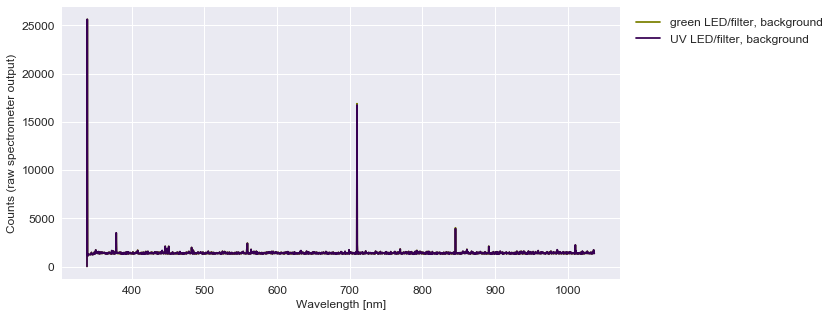

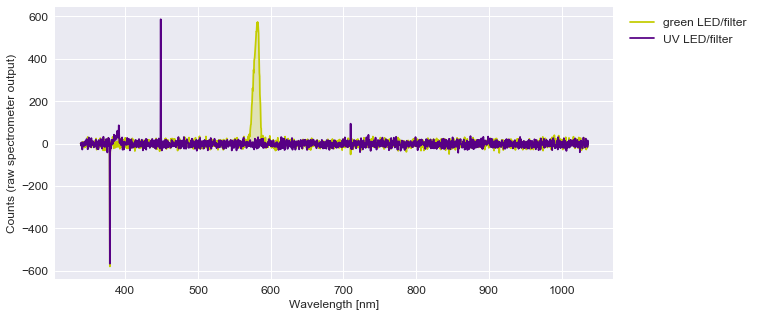

In [16]:
# Setup #2 green-UV lightcrafter 
# (through-the-condenser stimulation)
#
fileNameMask = "LEDs_Setup2_20180815c"

"""
# TFT screen, for comparison
#
fileNameMask  = "TFTMonitor_Samsung"
"""

for iLED, LED in enumerate(LEDs):
    # Check if file with the mask given above does already exist
    #
    fName         = "{0}{1}_{2}.txt".format(path_Data, fileNameMask, LED["name"])
    doesFileExist = os.path.isfile(fName)
    
    # At first, use colors that are defined for the current LED
    #
    col_lo = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.8)

    # LED background:
    #
    if not doesFileExist:
        # Measure ...
        #
        input("Measure background of {0} LED. Press Enter to start ...".format(LED["name"]))
        curr_background = []    
        for i in pbar.log_progress(range(LED["meas_n_trials"][0]), 
                                   name='Background, {0} LED'.format(LED["name"])):
            '''
            wavelengths, intensities = spectrometer.spectrum()
            '''
            wavelengths, intensities = sph.grabSpectrum(sph.DevType.OO_USB2000)
            curr_background.append(intensities)
        LED["spect_raw_bkg"] = np.mean(curr_background, axis=0)
    
    else:
        # ... or read data from file
        #
        if iLED == 0:
            wavelengths = np.loadtxt(fName, usecols=(0,))    
        LED["spect_raw_bkg"] = np.loadtxt(fName, usecols=(1,))

    # Plot ...
    #
    plt.figure(1)  
    plt.plot(wavelengths, LED["spect_raw_bkg"], color=col_lo, label=LED["name"] +" LED/filter, background")
    plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # LED at maximal intensity:
    #
    if not(os.path.isfile(fName)):
        # Measure ...
        #
        input("Prepare to measure maximal intensity {0} LED. Press Enter to continue...".format(LED["name"]))
        curr_spectrum    = []
        LED["spect_raw"] = []
        for i in pbar.log_progress(range(LED["meas_n_trials"][1]), 
                                   name='Maximal intensity, {0} LED'.format(LED["name"])):
            '''
            wavelengths, intensities = spectrometer.spectrum()
            '''
            wavelengths, intensities = sph.grabSpectrum(sph.DevType.OO_USB2000)
            curr_spectrum = intensities -LED["spect_raw_bkg"]
            LED["spect_raw"].append(curr_spectrum)
        LED["spect_raw_avg"] = np.mean(LED["spect_raw"], axis=0)    
    
    else:
        # .. or read data from file
        #
        LED["spect_raw_avg"] = np.loadtxt(fName, usecols=(2,))
        
    # Plot ...
    #
    plt.figure(2) 
    plt.plot(wavelengths, LED["spect_raw_avg"], color=col_hi, label=LED["name"] +" LED/filter")
    plt.fill(wavelengths, LED["spect_raw_avg"], facecolor=col_hi, alpha=0.25)        
    plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Save data for the current LED
    #
    if len(fileNameMask) > 0:
        np.savetxt(fName, np.transpose([wavelengths, LED["spect_raw_bkg"], LED["spect_raw_avg"]]),
                   header="wavelength\traw_bkg\traw_avg", newline=txtFileNewLineStr)    
        
# Disconnect spectrometer (if used)
#
sph.disconnect(sph.DevType.OO_USB2000)

### Postprocess the spectra
If the LEDs are dim and the spectral measurements are noisy, the spectra can be cleaned up by removing "shot noise" and fit. The available fit functions are a normal Gaussian (`Gauss()`) and an exponentially modified Gaussian (`EMG()`). More fit functions can be defined by the user, if needed. 

The function `removeShotNoise()` replaces single data points by the trace average if the datapoints are very (>`lim`) different from their direct neighboring datapoints.

In [17]:
def Gauss(x, h, x0, sigma):
    # h     := height (amplitude) of Gaussian
    # x0    := mean of Gaussian
    # sigma := (sigma)**2 variance of Gaussian
    #
    x = np.array(x)
    return h *np.exp(-(x -x0)**2 / (2 *sigma**2))

def EMG(x, h, x0, sigma, tau):
    # h     := height (amplitude) of Gaussian
    # x0    := mean of Gaussian
    # sigma := (sigma)**2 variance of Gaussian
    # tau   := 1/lamda, exponent relaxation time
    #
    s_t  = sigma/tau
    srph = np.sqrt(np.pi/2)
    x    = np.array(x)
    return h *s_t *srph *np.exp(0.5 *s_t**2 -(x -x0)/tau) *sse.erfc(1/np.sqrt(2) +(sigma/tau -(x -x0)/sigma))

def removeShotNoise(data, lim):
    avg  = np.mean(data)
    temp = [avg] *len(data)
    for iv, v in enumerate(data):
        if (iv > 0) and (iv < len(data)-1):
            if not((abs(data[iv] -data[iv-1]) > lim) and (abs(data[iv] -data[iv+1]) > lim)):
                temp[iv] = data[iv]
    return np.array(temp)            

Postprocess the spectra:
1. `useFit` select the fit function (or none), with `0`=no, `1`=use Gaussian, `2`=use exponentially modified Gaussian (EMG)
2. `useSNRemover`, 1=try removing shot noise using the threshold `SN_thres`
3. `sigmaStart` is the starting width for the Gaussian or EMG fit

Typical parameters for LED measurements are `useFit=1`, `useSNRemover=1`, `SN_thres=50`, and `sigmaStart=1`.  
For an RGB TFT screen, typical parameters are `useFit=2`, `useSNRemover=0`, `SN_thres=500`, and `sigmaStart=1`.


In [18]:
# Setup #2 green-UV lightcrafter 
# (through-the-condenser stimulation)
#
useFit       = 1   # 0=no, 1=use Gaussian, 2=use exponentially modified Gaussian (EMG)
useSNRemover = 1   # 0=no, 1=yes
SN_thres     = 50  # threshold for shot noise detection, 
sigmaStart   = 1

"""
# TFT screen, for comparison
#
useFit       = 2
useSNRemover = 0  
SN_thres     = 500
sigmaStart   = 1
"""

for iLED, LED in enumerate(LEDs):
    if useSNRemover > 0:
        # Try removing shot noise
        #
        LED["spect_raw_avg"] = removeShotNoise(LED["spect_raw_avg"], SN_thres)
    
    # Fit or use measured curves as they are
    #
    if useFit > 0:
        x     = wavelengths
        y     = LED["spect_raw_avg"]
        ampl  = y.max()
        mean  = x[np.argmax(y)] 
        sigma = sigmaStart
        tau   = 1

        if useFit == 1:
            popt, pcov = curve_fit(Gauss, x, y, p0=[ampl, mean, sigma])
            y_fit = Gauss(x, popt[0], popt[1], popt[2])
        elif useFit == 2:
            popt, pcov = curve_fit(EMG, x, y, p0=[ampl, mean, sigma, tau])
            y_fit = EMG(x, popt[0], popt[1], popt[2], popt[3])
   
    else: 
        y_fit = LED["spect_raw_avg"] 

    LED["peak_nm"] = spectrum.getPeak_in_nm(wavelengths, y_fit)        
    LED["spect_raw_fit"] = y_fit

Plot fits together with measured spectra:

(350, 650)

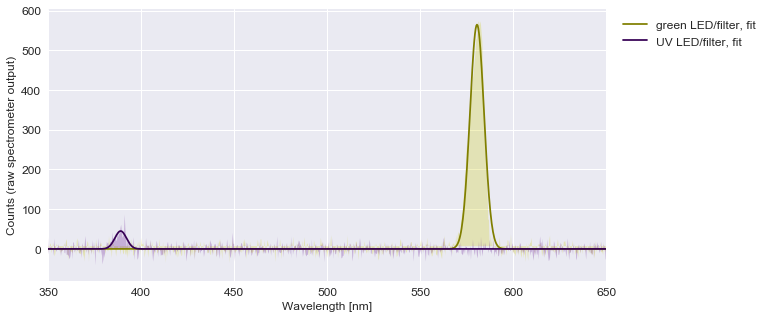

In [19]:
for iLED, LED in enumerate(LEDs):
    col_lo = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    plt.fill(wavelengths, LED["spect_raw_avg"], facecolor=col_hi, alpha=0.25)        
    plt.plot(wavelengths, LED["spect_raw_fit"], color=col_lo, label=LED["name"] +" LED/filter, fit")

plt.gca().set(xlabel="Wavelength [nm]", ylabel="Counts (raw spectrometer output)")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")   
plt.xlim((350, 650))

Now the measured LED/filter spectra are ...  
1. corrected using the calibration data of spectrometer (in [µJ/s]) and converted counts into [nW] (1 µJ/s = 1000 nW),
2. interpolated to match the 300 to 699 nm x scale of the opsin data (-> `spect_nw`), ...  
3. and a copy is made that is normalize to the area-under-the-curve (-> `spect`)

In [20]:
for iLED, LED in enumerate(LEDs):
    corrSpect            = np.multiply(LED["spect_raw_fit"], spm_calib_values) /int_time_s *1000
    LED["spect_nw"]      = np.interp(x_wavelen_nm, wavelengths, corrSpect)
    LED["spect_nw_norm"] = LED["spect_nw"] /np.amax(LED["spect_nw"])

Plot LED/filter spectra after spectrometer calibration together with spectrometer calibration data: 

(300, 650)

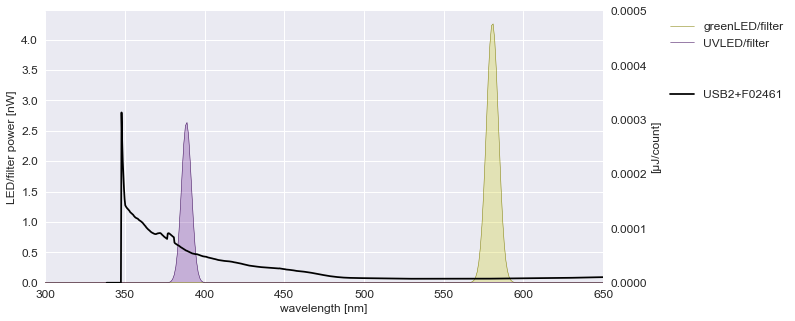

In [21]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for iLED, LED in enumerate(LEDs):
    col_lo = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    ax1.plot(x_wavelen_nm, LED["spect_nw"], color=col_lo, 
             label=LED["name"] +"LED/filter", linewidth=0.5)
    ax1.fill(x_wavelen_nm, LED["spect_nw"], facecolor=col_hi, alpha=0.25)        
    
ax1.set_xlabel("wavelength [nm]")        
ax1.set_ylabel("LED/filter power [nW]")        
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(ymin=0)

ax2.plot(spm_calib_wavelengths, spm_calib_values, color="black", label=spm_serialNumber)
ax2.set_ylabel("[µJ/count]")        
ax2.set_ylim(ymin=0, ymax=0.0005)
ax2.legend(bbox_to_anchor=(1.10, 0.75), loc="upper left")    
ax2.grid(False)
ax2.set_xlim((300, 650))

Plot calibrated (fitted) spectra of LED/filter combinations together with then photoreceptor opsin sensitivity curves and the filter spectra from the datasheets:

green	LED/filter, sum = 4.079e+01
UV	LED/filter, sum = 2.074e+01


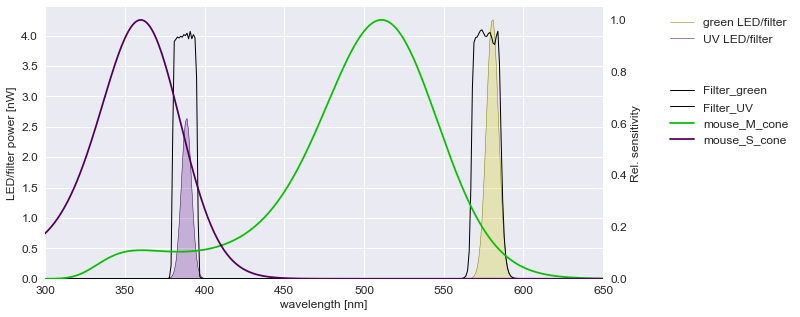

In [22]:
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for iLED, LED in enumerate(LEDs):
    col_lo = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.5)
    col_hi = spectrum.wavelength_to_rgb(LED["peak_nm"], darker=0.8)
    ax1.plot(x_wavelen_nm, LED["spect_nw"], color=col_lo, 
             label=LED["name"] +" LED/filter", linewidth=0.5)
    ax1.fill(x_wavelen_nm, LED["spect_nw"], facecolor=col_hi, alpha=0.25)    
    if len(LED["filter_spect"]) > 0:
        ax2.plot(x_wavelen_nm, LED["filter_spect"], color="black", label="Filter_" +LED["name"], linewidth=1)

    
for PR in PRs:
    if len(PR["spect"]) > 0:
        col = spectrum.wavelength_to_rgb(PR["peak_nm"], darker=0.75)
        ax2.plot(x_wavelen_nm, PR["spect"], color=col, label=PR["name"])

ax1.set_xlabel("wavelength [nm]")        
ax1.set_ylabel("LED/filter power [nW]")   
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(ymin=0)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.10, 0.75), loc="upper left")
ax2.set_ylim(ymin=0)
ax2.grid(False)
ax2.set_xlim((300, 650))

for iLED, LED in enumerate(LEDs):
    print("{0}\tLED/filter, sum = {1:.3e}".format(LED["name"], np.sum(LED["spect_nw"])))

## Determine effective photoreceptor stimulation

Calculate spectra for effective LED/filter combinations ...

In [23]:
for LED in LEDs:
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = PR["spect"] *LED["spect_nw_norm"]
            A_overlap       = np.trapz(temp["spect"])
            A_LED           = np.trapz(LED["spect_nw_norm"]) 
            temp["rel_exc"] = A_overlap/A_LED
            LED["effect_on_PR"].append(temp)

## Generate summary

1. Plot (normalized) spectra of photoreceptors and LED/filter combinations and print relative co-excitation of photoreceptors by the LEDs.

2. Calculate and print photo-isomerization rates for all LED/filter and photoreceptor combinations

Relative co-excitation:
  14.5% of mouse_M_cone by green
   0.0% of mouse_S_cone by green
  10.5% of mouse_M_cone by UV
  51.3% of mouse_S_cone by UV


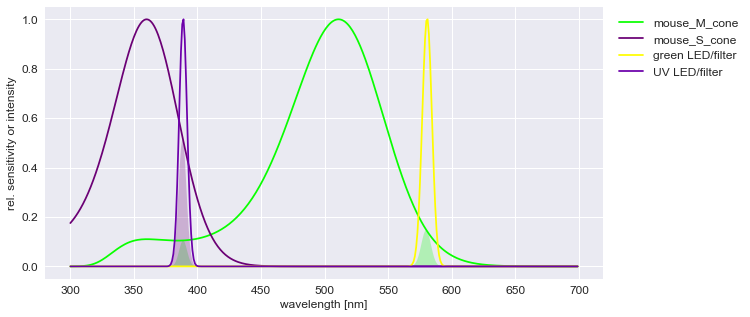

Maximal photoisomerization rates:
   17.6 10^3 photons/s in mouse_M_cone for green
    0.0 10^3 photons/s in mouse_S_cone for green
    4.4 10^3 photons/s in mouse_M_cone for UV
   21.2 10^3 photons/s in mouse_S_cone for UV


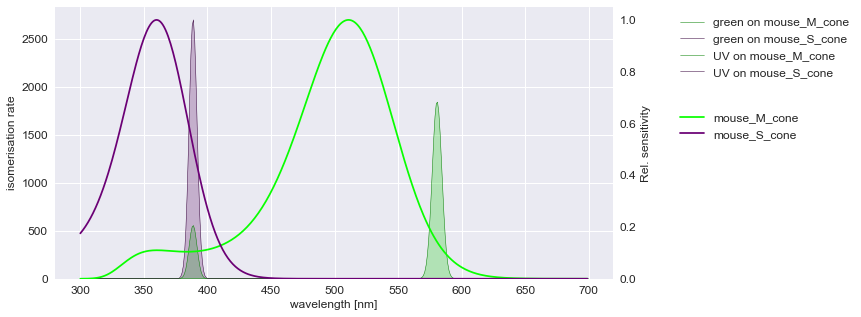

In [24]:
# Plot (normalized) spectra of photoreceptors and LED/filter combinations
#
for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=spectrum.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    if len(LED["spect_nw_norm"]) > 0:    
        colLED = spectrum.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["spect_nw_norm"], color=colLED, label=LED["name"] +" LED/filter")
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = spectrum.wavelength_to_rgb(PR["peak_nm"])
            plt.fill(x_wavelen_nm, effect["spect"], facecolor=colPR, alpha=0.25)    

plt.gca().set(xlabel="wavelength [nm]", ylabel="rel. sensitivity or intensity")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation:")
for LED in LEDs:        
    if len(LED["spect_nw_norm"]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"]*100, effect["PR_name"], LED["name"]))    
plt.show()


# Calculate and print photo-isomerization rates for all LED/filter and 
# photoreceptor combinations
#            
for iLED, LED in enumerate(LEDs):
    # Convert energy flux from [nW] (=readout of spectrometer) into [eV/s]
    #
    LED["pow_eflux"] = np.array((LED["spect_nw"] *1E-9 *eV_per_J), dtype=float)
    
    # Calculate the wavelength-dependent photon energy `Q` in [eV]
    #
    LED["pow_Q"]     = np.array((c*h/(x_wavelen_nm *1E-9)), dtype=float)
    
    # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
    # and then photon flux density `E` [photons/s /µm^2]
    #
    LED["pow_phi"]   = np.divide(LED["pow_eflux"],LED["pow_Q"])
    LED["pow_E"]     = LED["pow_phi"]/A_detect_um2
    
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                #
                A_collect             = PR["collecArea_um2"]
                effect["photon_rate"] = LED["pow_E"] *A_collect           
                
                # ... photoisomerizations [P*/photoreceptor /s]
                #
                effect["photoiso_rate"]       = effect["photon_rate"] *effect["rel_exc"]
                effect["photoiso_rate_total"] = np.sum(effect["photoiso_rate"])
                
                if (iLED == 0) and (iPR == 0): 
                    print("Maximal photoisomerization rates:")
                    
                print("{0:7.1f} 10^3 photons/s in {1} for {2}"
                     .format(effect["photoiso_rate_total"]/1E3, PR["name"], LED["name"]))

# Plot ...
#
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()

for PR in PRs:
    if len(PR["spect"]) > 0:
        ax2.plot(x_wavelen_nm, PR["spect"], 
                 color=spectrum.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])

for LED in LEDs:
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                col_lo = spectrum.wavelength_to_rgb(PR["peak_nm"], darker=0.5)
                col_hi = spectrum.wavelength_to_rgb(PR["peak_nm"], darker=0.8)
                ax1.plot(x_wavelen_nm, effect["photoiso_rate"], color=col_lo, 
                         label=LED["name"] +" on " +PR["name"], linewidth=0.5)
                ax1.fill(x_wavelen_nm, effect["photoiso_rate"], facecolor=col_hi, alpha=0.25)        

ax1.set_xlabel("wavelength [nm]")        
ax1.set_ylabel("isomerisation rate")   
ax1.legend(bbox_to_anchor=(1.10, 1), loc="upper left")
ax1.set_ylim(ymin=0)

ax2.set_ylabel("Rel. sensitivity")        
ax2.legend(bbox_to_anchor=(1.10, 0.65), loc="upper left")
ax2.set_ylim(ymin=0)
ax2.grid(False)   